In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    readHEPDataCsv,
    implementPairDecayLimit,
    fromHB5Table1,
    relevantGridEntries,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution

# ATLAS 13TeV LHC

## `H > a a > 4 gam`, higly boosted [1808.10515](https://arxiv.org/abs/1808.10515)


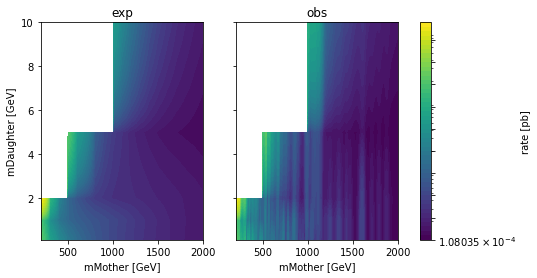

Looks good. Saving this to ggH_LHC13_ATLAS_37.json


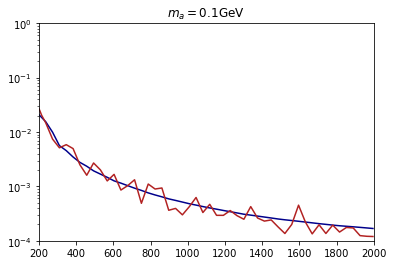

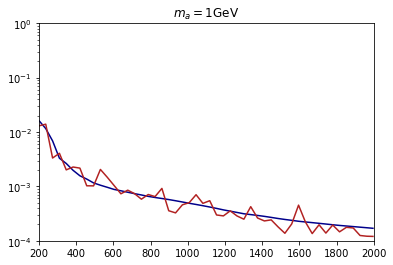

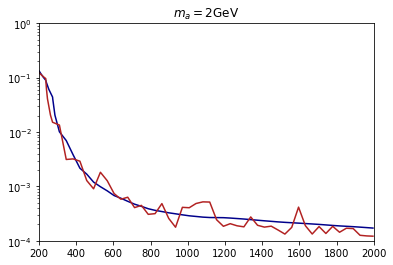

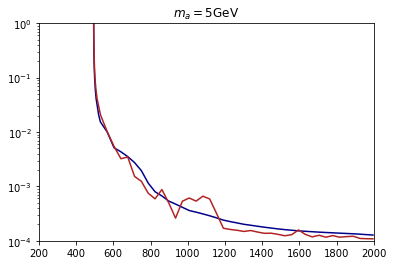

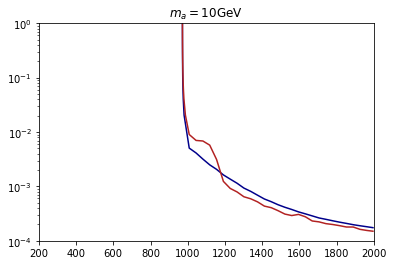

In [2]:
dfsObs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1692387/Table%203/1/csv", na_values="-"
)
dfsExp = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1692387/Table%204/1/csv", na_values="-"
)

def mergeObsExp(dfO, dfE):
    df = dfO.rename(
        columns={
            "$m_X$ [GeV]": "mMother",
            r"Cross section upper limit at 95% CL on $\sigma*\mathcal{B}$ [fb]": "obs",
        }
    )
    assert np.allclose(
        df.mMother,
        np.linspace(np.min(df.mMother), np.max(df.mMother), len(df.mMother)),
    )
    return df.merge(
        dfE.rename(
            columns={
                "$m_X$ [GeV]": "mMother",
                r"Cross section upper limit at 95% CL on $\sigma*\mathcal{B}$ [fb]": "exp",
            }
        )[["mMother", "exp"]],
        on="mMother",
        how="outer",
    ).interpolate()


df01 = mergeObsExp(dfsObs[0], dfsExp[0])
df01["mDaughter1"] = 0.1
df1 = mergeObsExp(dfsObs[1], dfsExp[1])
df1["mDaughter1"] = 1
df2 = mergeObsExp(dfsObs[2], dfsExp[2])
df2["mDaughter1"] = 2
df5 = mergeObsExp(dfsObs[3], dfsExp[3])
df5["mDaughter1"] = 5
df10 = mergeObsExp(dfsObs[4], dfsExp[4])
df10["mDaughter1"] = 10
assert np.allclose(df01.mMother, df1.mMother)
assert np.allclose(df01.mMother, df2.mMother)
assert np.allclose(df01.mMother, df5.mMother)
assert np.allclose(df01.mMother, df10.mMother)
relevantEntries = np.unique(
    np.concatenate(
        [
            relevantGridEntries(dff.mMother, dff[["exp", "obs"]].values)
            for dff in (df01, df1, df2, df5, df10)
        ]
    )
)
df = pd.concat(
    [
        df01.loc[relevantEntries],
        df1.loc[relevantEntries],
        df2.loc[relevantEntries],
        df5.loc[relevantEntries],
        df10.loc[relevantEntries],
    ]
).reset_index(drop=True)
# fb to pb
df.obs *= 1e-3
df.exp *= 1e-3
df.fillna(1e6, inplace=True)

limitFile = implementPairDecayLimit(
    "1808.10515",
    {
        "production": ["ggH"],
        "firstDecay": ["gamgam"],
        "secondDecay": ["gamgam"],
    },
    "https://doi.org/10.17182/hepdata.85728",
    df,
    massResolution={
        "firstDaughter": {
            "absolute": 0.02,
            "relative": 0.015,
        },  # lower absolute resolution than default because we are very light
        "secondDaughter": {"absolute": 0.02, "relative": 0.015},
        "mother": resolution.gamgam["default"],  # fits the numbers on p. 11 pretty well
    },
)
lim = HB.Limit(limitFile)

for ma in (0.1, 1, 2, 5, 10):
    pred = Predictions()
    hh = pred.addParticle(HP.NeutralScalar("hh"))
    h1 = pred.addParticle(HP.NeutralScalar("h1"))
    hh.setDecayWidth("h1", "h1", 1.0)
    h1.setDecayWidth("gamgam", 1.0)
    h1.setMass(ma)
    hm = np.linspace(200, 2000)
    r = np.linspace(1e-4, 1)

    def testAgainstLimit(mass, rate):
        hh.setMass(mass)
        hh.setCxn("LHC13", "ggH", rate)
        app = lim.apply(pred)
        if len(app) == 0:
            return (0, 0)
        return (app[0].expRatio(), app[0].obsRatio())

    test = np.frompyfunc(testAgainstLimit, 2, 2)
    XX, YY = np.meshgrid(hm, r)
    expR, obsR = test(XX, YY)
    fig, ax = plt.subplots()
    expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
    obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
    expCc.collections[0].set_label("expRatio = 1")
    obsCc.collections[0].set_label("obsRatio = 1")
    ax.set_yscale("log")
    ax.set_title(r"$m_a={}$GeV".format(ma))


# ATLAS 8TeV LHC

## `hSM > a a > 4 gam` [1509.05051](https://arxiv.org/abs/1509.05051)

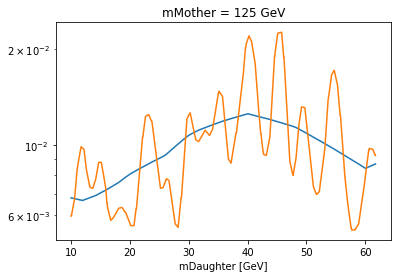

Looks good. Saving this to ggH_LHC8_ATLAS_20.json


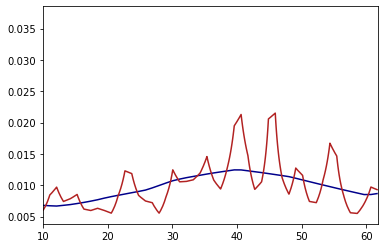

In [3]:
df = fromHB5Table1("5051_Atlas_gg-H-aa-gagagaga_20.3fb-1", "ATL")
df.rename(columns={"m": "mDaughter"}, inplace=True)
refCxn = 19.27  # given on p. 9
df.obs *= refCxn
df.exp *= refCxn
df["mMother"] = 125
limitFile = implementPairDecayLimit(
    1393757,
    {
        "production": ["ggH"],
        "firstDecay": ["gamgam"],
        "secondDecay": ["gamgam"],
    },
    "Fig. 8",
    df,
    collider="LHC8",
    massResolution={
        "firstDaughter": resolution.gamgam["default"],  # bin width
        "secondDaughter": resolution.gamgam["default"],
        "mother": {
            "absolute": 20,  # +-10GeV, guess
            "relative": 0,
        },
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("h1", "h1", 1.0)
h1.setDecayWidth("gamgam", 1.0)
hh.setMass(125)
hm = np.linspace(10, 61.75)
r = np.linspace(2e-4, 2e-3) * refCxn


def testAgainstLimit(mass, rate):
    h1.setMass(mass)
    hh.setCxn("LHC8", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
